In [1]:
!pip install nltk

In [2]:
import re  
import pandas as pd 
from time import time  
from collections import defaultdict 
import string 
import multiprocessing
import os
import gensim
import sklearn
from sklearn import linear_model
from collections import Counter
import numpy as np
import scipy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, cohen_kappa_score, classification_report
from nltk.tokenize import word_tokenize
import pickle

# word2vec
from gensim.models import Word2Vec, KeyedVectors, FastText
from gensim.models.phrases import Phrases, Phraser
from sklearn.model_selection import train_test_split
import logging

import nltk
from nltk.stem import PorterStemmer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
path =  "../../Data/train/df_us_train.pickle"
df_us_train = pickle.load(open(path, "rb"))

path =  "../../Data/train/df_es_train.pickle"
df_es_train = pickle.load(open(path, "rb"))

In [4]:
n_labels_us = df_us_train["label"].unique().shape[0]
n_labels_es = df_es_train["label"].unique().shape[0]

In [5]:
from collections import Counter

punctuation = string.punctuation + "«»“”‘’…—"

stopwords_spanish = pd.read_csv(
    'https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt'
).values
stopwords_spanish = Counter(stopwords_spanish.flatten().tolist())

stopwords_english = pd.read_csv(
    'https://raw.githubusercontent.com/Alir3z4/stop-words/master/english.txt'
).values
stopwords_english = Counter(stopwords_english.flatten().tolist())

## Contructor de sentence-embeddings

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [7]:
class StemmerTokenizer:
    def __init__(self, stopwords):
        self.ps = PorterStemmer()
        self.sw = stopwords
        
    def __call__(self, doc):
        doc_tok = word_tokenize(doc)
        doc_tok = [t for t in doc_tok if t not in self.sw]
        return [self.ps.stem(t) for t in doc_tok]

# Inicializamos tokenizador
tokenizador_english = StemmerTokenizer(stopwords_english)
tokenizador_spanish = StemmerTokenizer(stopwords_spanish)

In [8]:
bow_english = CountVectorizer(
    tokenizer= tokenizador_english,
    ngram_range=(1,1),
)

bow_spanish= CountVectorizer(
    tokenizer= tokenizador_spanish,
    ngram_range=(1,1),
)

ct_bow_english = ColumnTransformer([
    ("BOW", bow_english, "text")
])

ct_bow_spanish = ColumnTransformer([
    ("BOW", bow_spanish, "text")
])

### TF-IDF

In [9]:
pipe_tfidf_english = Pipeline(
    steps=[
        ('bow', ct_bow_english),
        ('tfidf', TfidfTransformer())
    ]
)

pipe_tfidf_spanish = Pipeline(
    steps=[
        ('bow', ct_bow_spanish),
        ('tfidf', TfidfTransformer())
    ]
)

In [10]:
%%time
es_train_tfidf_sentence_embedding = pipe_tfidf_spanish.fit_transform(df_es_train)

Wall time: 28.2 s


In [11]:
%%time
es_train_tfidf_sentence_embedding_id = df_es_train["id"]
es_train_tfidf_sentence_embedding_label = df_es_train["label"]

Wall time: 0 ns


In [12]:
from sklearn.cluster import KMeans

### KMeans

In [13]:
sample_index_es = np.random.RandomState(0).choice(range(es_train_tfidf_sentence_embedding.shape[0]), 20000)

In [14]:
X_train = es_train_tfidf_sentence_embedding[sample_index_es]

In [15]:
%%time
kmeans_es = KMeans(n_clusters=n_labels_es, random_state=0)
kmeans_es.fit(X_train)

Wall time: 2min 28s


KMeans(n_clusters=19, random_state=0)

In [16]:
kmeans_es_clusters = kmeans_es.labels_

In [17]:
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score

Silhouette

In [18]:
%%time
silhouette_es = silhouette_score(X_train, kmeans_es_clusters)
silhouette_es

Wall time: 9.51 s


0.010967909661029554

In [19]:
es_labels = es_train_tfidf_sentence_embedding_label.iloc[sample_index_es]

Rand index

In [20]:
%%time
rand_score_es = rand_score(es_labels, kmeans_es_clusters)
rand_score_es

Wall time: 80.1 ms


0.7803771988599429

Mutual information


In [21]:
%%time
nmi_es = normalized_mutual_info_score(es_labels, kmeans_es_clusters)
nmi_es

Wall time: 117 ms


0.025763075546449965

Homogeneity

In [22]:
%%time
hom_es = homogeneity_score(es_labels, kmeans_es_clusters)
hom_es

Wall time: 39 ms


0.024106566515444048

Completeness

In [23]:
%%time 
com_es = completeness_score(es_labels, kmeans_es_clusters)
com_es

Wall time: 36 ms


0.02766404026953652

V-measure

In [24]:
%%time 
v_me_es = v_measure_score(es_labels, kmeans_es_clusters)
v_me_es

Wall time: 36 ms


0.02576307554644997

In [25]:
from sklearn.metrics.pairwise import euclidean_distances

In [154]:
%%time
index_ord = []
size_clusters = []
cluters_ord = pd.Series(kmeans_es_clusters).value_counts().sort_values(ascending=False).index
for cluster in cluters_ord:
    index_cluster = list(np.where(kmeans_es_clusters==cluster)[0])
    index_cluster = np.random.RandomState(0).choice(
        index_cluster, 
        int(len(index_cluster)*0.1))
    size_clusters.append(len(index_cluster))
    index_ord += list(index_cluster)

Wall time: 47.1 ms


In [159]:
%%time
matriz_de_distancias_es = euclidean_distances(X_train[index_ord], X_train[index_ord])

Wall time: 84.6 ms


In [45]:
import matplotlib.pyplot as plt

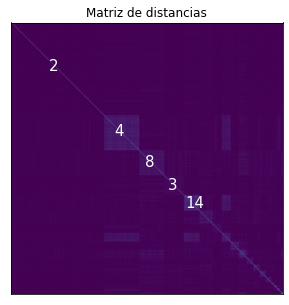

In [160]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.imshow(matriz_de_distancias_es, cmap="viridis_r");
ax.set_title("Matriz de distancias")
ax.set_yticks([])
y_text = [sum(size_clusters[:i])+size_clusters[i]/2 for i in range(len(size_clusters))]
x0 = -70
scale = 1.02
for cluster in range(5):
    ax.text((y_text[cluster]+x0)*scale, y_text[cluster]*scale, str(cluters_ord[cluster]), size=15, color="white")
ax.set_xticks([])
plt.show()

In [161]:
!pip install umap-learn
import umap

In [164]:
%%time
reducer = umap.UMAP(random_state=42)
umap_es = reducer.fit_transform(X_train)

Wall time: 32.1 s


In [190]:
df_umap_es = pd.DataFrame(umap_es)
df_umap_es["cluster"] = kmeans_es_clusters
df_umap_es["cluster"] = df_umap_es["cluster"].apply(str)
df_umap_es["label"] = df_es_train.iloc[sample_index_es]["label"].values

In [173]:
import plotly.express as px

In [195]:
fig = px.scatter(df_umap_es, x=0, y=1, color="cluster")
fig.show(rendere="notebook")

In [196]:
fig = px.scatter(df_umap_es, x=0, y=1, color="label")
fig.show(rendere="notebook")